##### Imports

In [949]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras import layers
from keras import Input
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping


##### Miscellaneous

In [950]:
# Used for interactive plots (zooming in)
%matplotlib widget

np.set_printoptions(threshold=np.inf, linewidth=300)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data acquisition method

##### Load from file (obtained through data extraction tool)

In [951]:
def get_stock_data_and_period_csv(filepath: str):
    df = pd.read_csv(filepath)

    start_date = df['Date'].iloc[0]
    end_date = df['Date'].iloc[-1]

    print('Time Period: ' + str(start_date) + ' to ' + str(end_date))

    return df, start_date, end_date

# Data Transform

In [952]:
def dataframe_copy(df: pd.DataFrame):
    df_copy = df.copy()
    return df_copy

In [953]:
def dataframe_clean(df: pd.DataFrame):
    clean_df = df.dropna()
    clean_df = clean_df.drop(['Date'], axis=1)  # we remove 'Date' here so the original data is untouched.
    return clean_df

In [954]:
def dataframe_stats(df: pd.DataFrame):
    print(df.shape)
    print(df.columns)
    print(df.isnull().sum())

##### Preparing data for loading into model

In [955]:
def set_column_as_first(df: pd.DataFrame, col_name: str):
    col_loc = df.columns.get_loc(col_name)
    if col_loc != 0:
        cols = list(df.columns)
        a, b = cols.index(col_name), cols.index(df.columns[0])
        cols[b], cols[a] = cols[a], cols[b]
        df = df[cols]
    
    return df

In [956]:
# used for plotting purposes
def scaler_fit_column(df: pd.DataFrame, target: str = 'Close'):
    scaler = MinMaxScaler(feature_range=(0, 1))   # fit to data, used by graphs to plot prices instead of values in the (0, 1) range
    scaler.fit(df[[target]])

    return scaler

In [957]:
def transform_data(df: pd.DataFrame):
    # Scale the data
    cols = df.columns

    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df)    # fit and transform for all data
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = cols

    return df_scaled

In [958]:
# by default, the target is the 'Close' price of the stock
def get_features_and_target(df: pd.DataFrame, target: str = 'Close'):
    df_features = df
    df_target = df[[target]]

    return df_features, df_target

##### Train Data Setup

In [959]:
def setup_train_data(features: pd.DataFrame, target: pd.DataFrame, train_data_percent: float = 0.8):
    train_data_len = math.ceil(len(features.to_numpy()) * train_data_percent)

    train_x = features[0:train_data_len].to_numpy()
    train_y = target[0:train_data_len].to_numpy()

    return train_x, train_y, train_data_len


In [960]:
def prepare_train_as_sliding_window(train_x, train_y, sliding_window_size: int = 5):
    x_train_sw = []
    y_train_sw = []

    # The sliding window size (in days) we use as input. There are 5 trading days in a week
    for i in range(sliding_window_size, len(train_x)):
        x_train_sw.append(train_x[i-sliding_window_size:i,:])
        y_train_sw.append(train_y[i:i+1, 0])

    x_train_sw, y_train_sw = np.array(x_train_sw), np.array(y_train_sw)   # convert to numpy array

    return x_train_sw, y_train_sw

In [961]:
def setup_test_data(features, target, train_data_len):
    test_x = features[train_data_len:].to_numpy()
    test_y = target[train_data_len:].to_numpy()

    return test_x, test_y

In [962]:
def prepare_test_as_sliding_window(test_x, test_y, sliding_window_size: int = 5):
    x_test_sw = []  # features
    y_test_sw = []  # target
    y_remaining = []    # features remaining

    for i in range(sliding_window_size, len(test_x)):
        x_test_sw.append(test_x[i-sliding_window_size:i,:])
        y_test_sw.append(test_y[i:i+1,0])
        y_remaining.append(test_x[i:i+1,1:])

    x_test_sw = np.array(x_test_sw)
    y_test_sw = np.array(y_test_sw)
    y_remaining = np.array(y_remaining)

    return x_test_sw, y_test_sw, y_remaining

# Transformer Model

In [963]:
def transformer_encoder(
    inputs, 
    head_size, 
    num_heads, 
    ff_dim, 
    dropout=0.0
):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [964]:
def build_model(    
    x_train_sw,
    sliding_window_size: int = 5,
    head_size=128,
    num_heads=16,
    ff_dim=8,
    num_transformer_blocks=8,
    mlp_units=128,
    mlp_dropout=0.05,
    dropout=0.05,
):
    input_shape = x_train_sw.shape[1:]
    input_shape = (sliding_window_size, input_shape[1])
    inputs = Input(shape=input_shape)

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    mlp_units_array = [mlp_units]
    for dim in mlp_units_array:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)    # this tells us that the output is one prediction step.
    return Model(inputs, outputs)

##### Model Callbacks

In [965]:
# you can add new callbacks by adding them here
def get_model_callbacks():
    # Adding EarlyStopping callback (for lots of epochs)
    # 33 is a nice sweet spot for allowing a stagnant model in training to get back to reducing validation loss.
    early_stopping = EarlyStopping(patience=33, restore_best_weights=True)

    # Adding ModelCheckpoint callback
    # Define the path to save the best weights. The best weights will be restored in training when new validation loss is higher than the previous validation loss.
    checkpoint_path = 'best_weights.h5'
    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

    model_callbacks = [early_stopping, checkpoint]

    return model_callbacks

##### Model Creation and Training

In [966]:
def compile_model(model: Model, metrics=['mse', 'mae', 'mape'], learning_rate=0.0001):
    model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=metrics
    )

    return model

# General guidelines for hyperparameters
# - head_size and mlp_units should be large values (i.e. 256 for head_size and mlp_units, 8 num_heads, ff_dim, num_transformer_blocks)
# - you can't just keep increasing the hyperparameter values, memory is your constraint.

##### Model Fitting

In [967]:
# train the model in a function here.
def train_model(model: Model, model_callbacks, x_train, y_train, train_validation_split: float = 0.8, epochs: int = 20, batch_size: int = 128):  
    # A higher train_validation_split value will mean more data is used for training, less for validation.
    history = model.fit(
                x_train,
                y_train,
                validation_split=1-train_validation_split,  # lil bug was hiding here
                epochs=epochs,
                batch_size=batch_size,
                callbacks=model_callbacks
            )

    # Load the best weights into the model
    model.load_weights('best_weights.h5')

    return model, history

##### Model Evaluation

In [968]:
def evaluate_model(model: Model, x_test_sw, y_test_sw):
    model.evaluate(x_test_sw, y_test_sw, verbose=1)

##### Performing Prediction Steps

In [969]:
# This function performs a single step prediction and adds supporting values from data for another prediction. Calling this multiple times resembles a multistep model.
# Prediction steps uses ground truth data (except target) per step.
def perform_prediction_step_on_ground_truth(model: Model, input_data, remaining_y):

    # reshape the input to (1, sliding_window_size, features)
    test_input = np.reshape(input_data, (1, input_data.shape[0], input_data.shape[1]))

    # perform a prediction step
    prediction_value = model.predict(test_input, verbose=0)
    last_gt_price = np.reshape(input_data[0][0], (1, 1))

    # concatenate the prediction value to beginning of the data columns
    final = np.concatenate((last_gt_price, remaining_y), axis=1)

    # concatenate the input data to the beginning of
    test_x = np.concatenate((input_data, final), axis=0)

    # shifting the sliding window one step forward
    test_x = test_x[1:]

    return test_x, prediction_value

In [970]:
# This function performs a single step prediction without adding feature values. 
def perform_prediction_step_tomorrow(model: Model, input_data):
    test_input = np.reshape(input_data,(1,input_data.shape[0], input_data.shape[1]))
    prediction_value = model.predict(test_input)
    return prediction_value

In [971]:
def perform_model_predictions(model, test_x, y_remaining):
    prediction_values = []
    new_test_x = test_x[0].copy()

    # Repeated single step prediction with the available data
    for i in range(y_remaining.shape[0]):
        new_test_x, prediction = perform_prediction_step_on_ground_truth(model, new_test_x, y_remaining[i])
        prediction_values.append(prediction)

    # Single step prediction into the future!
    prediction = perform_prediction_step_tomorrow(model, new_test_x)
    prediction_values.append(prediction)

    pred_vals = np.array(prediction_values)
    pred_vals = pred_vals.squeeze(1)

    return pred_vals

##### RMSE

In [972]:
def calculate_rmse(actual_values, predicted_values):
    rmse = mean_squared_error(actual_values, predicted_values, squared=False)
    return rmse

# Graphs Output

#### Preparation for Output

In [973]:
def prepare_x_axis_prediction_ground_truth(y_train_sw, y_test_sw, predicted_values): 
    # we are concatenating the train data in order to show predicted values on top of ground truth values. This includes the single prediction step into the future.
    predicted = np.concatenate((y_train_sw, predicted_values), axis=0)
    ground_truth = np.concatenate((y_train_sw, y_test_sw), axis=0)

    return predicted, ground_truth

#### Prediction vs Ground Truth Graph

In [974]:
# TODO Fix plotting of the vertical line for test (something up with train_data_len...)

def plot_prediction_vs_gt(scaler: MinMaxScaler, predicted, ground_truth, start_date, end_date, train_data_len, train_validation_split, sliding_window_size):
    # Use the unscaled data to see prices
    scaler_pred = scaler.inverse_transform(predicted)
    scaler_ground_truth = scaler.inverse_transform(ground_truth)

    plt.figure(figsize=(15, 6))

    # Adding the predicted, ground truth, and tomorrow's prediction
    plt.plot(scaler_pred.flatten(), label='Next Trading Day Prediction', color='#0000FF')
    plt.plot(scaler_pred[:-1].flatten(), label='Predicted', color='#00FF00')
    plt.plot(scaler_ground_truth.flatten(), label='Ground Truth', color='#FF8800')

    # Adding vertical lines indicating different data usages
    plt.axvline(x=0, label='Train', color='#FF0000', ls=(0, (1, 4)))  # this data was used for model training by keras.
    plt.axvline(x=train_data_len * train_validation_split, label='Validation', color='#00FF00', ls=(0, (1, 4)))   # this data was used for model validation by keras.
    plt.axvline(x=scaler_ground_truth.size - (scaler_pred.size - train_data_len) - sliding_window_size, label='Test', color='#0000FF', ls=(0, (1, 4)))   # this is the test data - predictions are made on it, and we can compare it to ground truth.
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,2,0,3,4,5]

    plt.xlabel('Date (' + start_date + ' to ' + end_date + ') + 1')
    plt.ylabel('Stock Price ($)')
    plt.title('Prediction vs Ground Truth')
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    plt.savefig('Prediction.png')
    plt.show()


#### Daily Closing Prices

In [975]:
def plot_daily_close(df: pd.DataFrame, ticker: str):
    # Plotting daily closing prices
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], linestyle='-')
    plt.xlabel('Date')
    plt.gca().set_xticklabels([])
    plt.xticks([])
    plt.ylabel('Closing Price')
    plt.title(ticker + ' Daily Closing Prices')
    plt.show()

#### Daily Stock Returns

In [976]:
def plot_daily_returns(df: pd.DataFrame, ticker: str):
    df['Daily_Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)

    plt.figure(figsize=(12, 6))

    # Plotting daily stock returns
    plt.plot(df['Date'][1:], df['Daily_Return'][1:], linestyle='-')
    plt.xlabel('Date')
    plt.gca().set_xticklabels([])
    plt.xticks([])
    plt.ylabel('Daily Return')
    plt.title(ticker + ' Daily Stock Return')
    plt.show()

#### Loss from Training and Validation

In [977]:
def plot_loss_chart(history):
    # Accessing training and validation loss from the history object
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Generating a list of epochs (x-axis)
    epochs = range(1, len(training_loss) + 1)


    plt.figure(figsize=(8, 4))

    # Plotting the training and validation loss over iterations
    plt.plot(epochs, training_loss, label='Training Loss', linestyle='-')
    plt.plot(epochs, validation_loss, label='Validation Loss', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

#### Pie charts

In [978]:
def calculate_pie_chart_values(ground_truth, predicted, tolerance_percent: int = 2):
    # Getting data for pie chart
    pie_chart_data = pd.DataFrame({
        'Predicted': predicted[:-1].flatten(),  # remove last predicted 'future' value
        'Ground_Truth': ground_truth.flatten()
    })


    # Calculating all of the necessary things for the pie chart.

    # tolerance = ((pred - gt) / gt) * 100 < tolerance_percent  # determines if the model predicted under some tolerance percent
    # gt movement = gtcurr - gtprev > 0                         # determines if the ground truth movement was up or down
    # pred movement = pred - gtprev > 0                         # determines if the model prediction was up or down
    # if the gt movement and prediction movement are both T or F, then the model predicted correctly upwards/downards.
    # if the gt movement and prediction movement are T/F or F/T, then the model predicted incorrectly downwards for T/F and incorrectly upwards for F/T
    # if the tolerance is under the %, then the model predicted accurately.
    # if the tolerance is over the %, then the model predicted inaccurately.

    predicted_values = np.array(pie_chart_data['Predicted'])
    ground_truth_values = np.array(pie_chart_data['Ground_Truth'])

    #tolerance_percent = 2   # integer used to determine if the model was accurate or not. 1 = 1% tolerance
    tolerance = []
    ground_truth_movement = []  # T is up, F is down
    prediction_movement = []    # T is up, F is down

    # append bool values to each array based on the requirements
    for i in range(1, ground_truth_values.size):
        tolerance.append(True if abs((predicted_values[i] - ground_truth_values[i]) / ground_truth_values[i]) * 100 < tolerance_percent else False)
        ground_truth_movement.append(True if ground_truth_values[i] - ground_truth_values[i-1] > 0 else False)
        prediction_movement.append(True if predicted_values[i] - ground_truth_values[i-1] > 0 else False)



    # Categorizations of model movement prediction, ground truth movement, and tolerance 
    correct = 0
    incorrect = 0
    under = 0
    over = 0

    correct_upwards_under = 0
    correct_upwards_over = 0
    correct_downwards_under = 0
    correct_downwards_over = 0
    incorrect_upwards_under = 0
    incorrect_upwards_over = 0
    incorrect_downwards_under = 0
    incorrect_downwards_over = 0



    # TODO research a cleaner way of doing this...
    for i in range(0, ground_truth_values.size - 1):
        correct += int((ground_truth_movement[i] == True and prediction_movement[i] == True) or (ground_truth_movement[i] == False and prediction_movement[i] == False))     # model predicted correct direction
        incorrect += int((ground_truth_movement[i] == True and prediction_movement[i] == False) or (ground_truth_movement[i] == False and prediction_movement[i] == True))  # model predicted wrong direction
        under += int(tolerance[i] == True)  # model predicted under tolerance
        over += int(tolerance[i] == False)  # model predicted over tolerance

        correct_upwards_under += int(ground_truth_movement[i] == True and prediction_movement[i] == True and tolerance[i] == True)         # model predicted correctly upwards under tolerance
        correct_upwards_over += int(ground_truth_movement[i] == True and prediction_movement[i] == True and tolerance[i] == False)         # model predicted correctly updwards over tolerance
        correct_downwards_under += int(ground_truth_movement[i] == False and prediction_movement[i] == False and tolerance[i] == True)     # model predicted correctly downwards under tolerance
        correct_downwards_over += int(ground_truth_movement[i] == False and prediction_movement[i] == False and tolerance[i] == False)     # model predicted correctly downwards over tolerance
        incorrect_upwards_under += int(ground_truth_movement[i] == False and prediction_movement[i] == True and tolerance[i] == True)      # model predicted incorrectly upwards under tolerance
        incorrect_upwards_over += int(ground_truth_movement[i] == False and prediction_movement[i] == True and tolerance[i] == False)      # model predicted incorrectly upwards over tolerance
        incorrect_downwards_under += int(ground_truth_movement[i] == True and prediction_movement[i] == False and tolerance[i] == True)    # model predicted incorrectly downwards under tolerance
        incorrect_downwards_over += int(ground_truth_movement[i] == True and prediction_movement[i] == False and tolerance[i] == False)    # model predicted incorrectly downwards over tolerance

    tol_per = str(tolerance_percent)
    print('Number of times the model predicted CORRECT direction: ' + str(correct))
    print('Number of times the model predicted INCORRECT direction: ' + str(incorrect))
    print('Number of times the model predicted UNDER ' + tol_per + '% tolerance: ' + str(under))
    print('Number of times the model predicted OVER ' + tol_per + '% tolerance: ' + str(over))

    print('Number of times the model CORRECTLY predicted UPWARD movement UNDER ' + tol_per + '% tolerance: ' + str(correct_upwards_under))
    print('Number of times the model CORRECTLY predicted UPWARD movement OVER ' + tol_per + '% tolerance: ' + str(correct_upwards_over))
    print('Number of times the model CORRECTLY predicted DOWNWARD movement UNDER ' + tol_per + '% tolerance: ' + str(correct_downwards_under))
    print('Number of times the model CORRECTLY predicted DOWNWARD movement OVER ' + tol_per + '% tolerance: ' + str(correct_downwards_over))
    print('Number of times the model INCORRECTLY predicted UPWARD movement UNDER ' + tol_per + '% tolerance: ' + str(incorrect_upwards_under))
    print('Number of times the model INCORRECTLY predicted UPWARD movement OVER ' + tol_per + '% tolerance: ' + str(incorrect_upwards_over))
    print('Number of times the model INCORRECTLY predicted DOWNWARD movement UNDER ' + tol_per + '% tolerance: ' + str(incorrect_downwards_under))
    print('Number of times the model INCORRECTLY predicted DOWNWARD movement OVER ' + tol_per + '% tolerance: ' + str(incorrect_downwards_over))

    # big tuple idk how else to do it...
    return (correct, incorrect, under, over, 
        correct_upwards_under, correct_upwards_over, correct_downwards_under, correct_downwards_over, 
        incorrect_upwards_under, incorrect_upwards_over, incorrect_downwards_under, incorrect_downwards_over)

In [979]:
# Helper function to remove zero-percent percentages from the pie chart
def auto_percent(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

In [980]:
# Data for the pie chart. Use any of these to sort the data by their respective values.

def plot_pie_categories(tolerance_percent, correct_upwards_under, correct_downwards_under, incorrect_upwards_under, incorrect_downwards_under, correct_upwards_over, correct_downwards_over, incorrect_upwards_over, incorrect_downwards_over):
    # the below are only used for plot_pie_categories
    #labels_correctness = ['Correct Upwards Under', 'Correct Upwards Over', 'Correct Downwards Under', 'Correct Downwards Over', 'Incorrect Upwards Under', 'Incorrect Upwards Over', 'Incorrect Downwards Under', 'Incorrect Downwards Over']
    #sizes_correctness = [correct_upwards_under, correct_upwards_over, correct_downwards_under, correct_downwards_over, incorrect_upwards_under, incorrect_upwards_over, incorrect_downwards_under, incorrect_downwards_over]
    labels_tolerance = ['Correct Upwards Under', 'Correct Downwards Under', 'Incorrect Upwards Under', 'Incorrect Downwards Under', 'Correct Upwards Over', 'Correct Downwards Over', 'Incorrect Upwards Over', 'Incorrect Downwards Over']
    sizes_tolerance = [correct_upwards_under, correct_downwards_under, incorrect_upwards_under, incorrect_downwards_under, correct_upwards_over, correct_downwards_over, incorrect_upwards_over, incorrect_downwards_over]

    colors = ['#00FF00', '#00AA00', '#FFFF00', '#AAAA44', '#00FFFF', '#008B8B', '#FF0000', '#880000']

    plt.figure(figsize=(12, 6))

    # Create the pie chart
    plt.pie(sizes_tolerance, labels=labels_tolerance, labeldistance=None, autopct=auto_percent, startangle=0, colors=colors)
    plt.legend(labels_tolerance, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Correctness-Directionality-Tolerance Summary (' + str(tolerance_percent) + '% tolerance)')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [981]:
def plot_pie_correctness(correct: int, incorrect: int):
    colors=['#00FF00', '#FF0000']
    correctness = [correct, incorrect]
    correctness_labels = ['Correct', 'Incorrect']

    plt.figure(figsize=(12, 6))
    plt.pie(correctness, labels=['Correct', 'incorrect'], labeldistance=None, autopct=auto_percent, startangle=0, colors=colors)
    plt.legend(correctness_labels, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Correctness (Directionality)')
    plt.axis('equal')
    plt.show()

In [982]:
def plot_pie_tolerance(tolerance_percent: int, under: int, over: int):
    colors=['#00FF00', '#FF0000']
    under_over = [under, over]
    under_over_labels = ['Under', 'Over']

    plt.figure(figsize=(12, 6))
    plt.pie(under_over, labels=under_over_labels, labeldistance=None, autopct=auto_percent, startangle=0, colors=colors)
    plt.legend(under_over_labels, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Tolerance (%' + str(tolerance_percent) + ')')
    plt.axis('equal')
    plt.show()

# The entire program

In [983]:
ticker = 'QQQ'
target_col = 'Close'
filepath = 'data/ta_stock_data_' + ticker + '.csv'   # use 'ta_stock_data_TICKER.csv' for technical analysis, or 'ps_stock_data_TICKER.csv' for parallel stock.
columns_to_keep = [
    'Date', 
    'Open', 'High', 'Low', 'Close', 'Volume', 
    #'rsi', 'macd', 'macd_signal', 'bbands_upper', 'bbands_middle', 'bbands_lower', 
    #'obv', 'adx', 'adx_pos', 'adx_neg', 'adi', 
    #'ema_50', 'sma_50'
    ]

train_data_percent = 0.9        # data split between train/validation and test      TrV <-> Te
train_validation_split = 0.9    # data split between train and validation           Tr <-> V
sliding_window_size = 5         # number of lags used as input, applied for every feature
tolerance_percent = 2           # percent used to accept a prediction as 'correct', after accounting for direction

# *** A Note on Train Validation Split for Stocks ***
#   There is a chance that, due to a stock price rising over the course of its history, the model may not be able to account for all possible input values.
#   Example: SPY has consistently gone up, and the model gets trained on the first 5 years of its history. 
#   After that, the inputs will undoubtedly be larger than the model expects, so its predictions are quite unstable.
#   The ideal training data contains the highest price recorded in the stock's history.

df, start_date, end_date = get_stock_data_and_period_csv(filepath)
df = df[columns_to_keep]

df

Time Period: 2014-07-30 to 2023-10-12


,Date,Open,High,Low,Close,Volume
0,2014-07-30,97.139999,97.320000,96.599998,96.980003,35348500
1,2014-07-31,96.180000,96.339996,94.879997,95.019997,50047900
2,2014-08-01,94.820000,95.339996,94.040001,94.669998,60708000
3,2014-08-04,94.870003,95.690002,94.519997,95.320000,33230500
4,2014-08-05,94.940002,95.209999,94.150002,94.589996,50331100
...,...,...,...,...,...,...
2313,2023-10-06,355.649994,365.910004,354.850006,364.700012,74959200
2314,2023-10-09,362.299988,367.109985,360.779999,366.559998,45304800
2315,2023-10-10,366.899994,371.279999,366.390015,368.589996,46968800
2316,2023-10-11,369.940002,371.410004,368.190002,371.220001,38215100


In [984]:
df_copy = dataframe_copy(df)
df = dataframe_clean(df)
dataframe_stats(df)

df

(2318, 5)
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


,Open,High,Low,Close,Volume
0,97.139999,97.320000,96.599998,96.980003,35348500
1,96.180000,96.339996,94.879997,95.019997,50047900
2,94.820000,95.339996,94.040001,94.669998,60708000
3,94.870003,95.690002,94.519997,95.320000,33230500
4,94.940002,95.209999,94.150002,94.589996,50331100
...,...,...,...,...,...
2313,355.649994,365.910004,354.850006,364.700012,74959200
2314,362.299988,367.109985,360.779999,366.559998,45304800
2315,366.899994,371.279999,366.390015,368.589996,46968800
2316,369.940002,371.410004,368.190002,371.220001,38215100


In [985]:
df = set_column_as_first(df, col_name=target_col)

df

,Close,High,Low,Open,Volume
0,96.980003,97.320000,96.599998,97.139999,35348500
1,95.019997,96.339996,94.879997,96.180000,50047900
2,94.669998,95.339996,94.040001,94.820000,60708000
3,95.320000,95.690002,94.519997,94.870003,33230500
4,94.589996,95.209999,94.150002,94.940002,50331100
...,...,...,...,...,...
2313,364.700012,365.910004,354.850006,355.649994,74959200
2314,366.559998,367.109985,360.779999,362.299988,45304800
2315,368.589996,371.279999,366.390015,366.899994,46968800
2316,371.220001,371.410004,368.190002,369.940002,38215100


In [986]:
scaler = scaler_fit_column(df, target=target_col)
df = transform_data(df)

df

,Close,High,Low,Open,Volume
0,0.016624,0.014994,0.037314,0.021323,0.147538
1,0.010346,0.011894,0.031903,0.018277,0.224254
2,0.009225,0.008731,0.029260,0.013962,0.279890
3,0.011307,0.009838,0.030770,0.014120,0.136484
4,0.008969,0.008319,0.029606,0.014342,0.225732
...,...,...,...,...,...
2313,0.874151,0.864613,0.849830,0.841599,0.354267
2314,0.880109,0.868409,0.868487,0.862700,0.199500
2315,0.886611,0.881599,0.886138,0.877296,0.208184
2316,0.895035,0.882011,0.891801,0.886943,0.162499


In [987]:
features, target = get_features_and_target(df, target=target_col)

print(features.shape)
print(target.shape)

(2318, 5)
(2318, 1)


In [988]:
features

,Close,High,Low,Open,Volume
0,0.016624,0.014994,0.037314,0.021323,0.147538
1,0.010346,0.011894,0.031903,0.018277,0.224254
2,0.009225,0.008731,0.029260,0.013962,0.279890
3,0.011307,0.009838,0.030770,0.014120,0.136484
4,0.008969,0.008319,0.029606,0.014342,0.225732
...,...,...,...,...,...
2313,0.874151,0.864613,0.849830,0.841599,0.354267
2314,0.880109,0.868409,0.868487,0.862700,0.199500
2315,0.886611,0.881599,0.886138,0.877296,0.208184
2316,0.895035,0.882011,0.891801,0.886943,0.162499


In [989]:
target

,Close
0,0.016624
1,0.010346
2,0.009225
3,0.011307
4,0.008969
...,...
2313,0.874151
2314,0.880109
2315,0.886611
2316,0.895035


In [990]:
train_x, train_y, train_data_len = setup_train_data(features, target, train_data_percent)
x_train_sw, y_train_sw = prepare_train_as_sliding_window(train_x, train_y, sliding_window_size)

print(train_x.shape)
print(train_y.shape)
print(train_data_len)
print(x_train_sw.shape)
print(y_train_sw.shape)

(2087, 5)
(2087, 1)
2087
(2082, 5, 5)
(2082, 1)


In [991]:
test_x, test_y = setup_test_data(features, target, train_data_len)
x_test_sw, y_test_sw, y_remaining = prepare_test_as_sliding_window(test_x, test_y, sliding_window_size)

print(test_x.shape)
print(test_y.shape)
print(x_test_sw.shape)
print(y_test_sw.shape)
print(y_remaining.shape)

(231, 5)
(231, 1)
(226, 5, 5)
(226, 1)
(226, 1, 4)


In [992]:
model = build_model(
    x_train_sw, 
    sliding_window_size,
    head_size=128,      # head size of multi-head attention of transformer encoder blocks            # low impact on training time
    num_heads=4,        # number of heads in multi-head attention of transformer encoder blocks     # low impact on training time
    ff_dim=4,           # number of filters in conv1d of transformer encoder blocks                 # medium impact on training time
    num_transformer_blocks=4,   # number of transformer encoder blocks                              # HIGH impact on training time
    mlp_units=64,      # number of mlp units                                                       # low impact on training time
    mlp_dropout=0.4,    # dropout of mlp units                                                      # reduces overfitting
    dropout=0.4         # dropout of multi-head attention transformer encoder blocks                # reduces overfitting
    )
model = compile_model(model)

In [993]:
# the best model trains fast, achieves small validation loss, and scores a low RMSE value.
model, history = train_model(model, get_model_callbacks(), x_train_sw, y_train_sw, train_validation_split, epochs=200, batch_size=128)

# in general, a val_loss of ~0.00100 (or below) is usually an indicator that the model will perform well on training (~0.02 RMSE). Of course, it varies with luck.
evaluate_model(model, x_test_sw, y_test_sw) 

Epoch 1/200
14/15 [===========================>..] - ETA: 0s - loss: 0.2930 - mse: 0.2930 - mae: 0.4006 - mape: 46206.3320
Epoch 1: val_loss improved from inf to 0.57674, saving model to best_weights.h5
15/15 [==============================] - 5s 87ms/step - loss: 0.2896 - mse: 0.2896 - mae: 0.3977 - mape: 44215.0195 - val_loss: 0.5767 - val_mse: 0.5767 - val_mae: 0.7517 - val_mape: 106.0267
Epoch 2/200
15/15 [==============================] - ETA: 0s - loss: 0.2248 - mse: 0.2248 - mae: 0.3509 - mape: 125902.5234
Epoch 2: val_loss improved from 0.57674 to 0.51028, saving model to best_weights.h5
15/15 [==============================] - 1s 51ms/step - loss: 0.2248 - mse: 0.2248 - mae: 0.3509 - mape: 125902.5234 - val_loss: 0.5103 - val_mse: 0.5103 - val_mae: 0.7049 - val_mape: 99.3805
Epoch 3/200
14/15 [===========================>..] - ETA: 0s - loss: 0.2051 - mse: 0.2051 - mae: 0.3324 - mape: 265210.6250
Epoch 3: val_loss improved from 0.51028 to 0.46627, saving model to best_weights.

In [994]:
predicted_values = perform_model_predictions(model, x_test_sw, y_remaining)
calculate_rmse(y_test_sw, predicted_values[:-1])    # use all except the last prediction

# RMSE can be interpreted as: the model, on average, predicts within x% of the ground truth price. (where 0.01 corresponds to 1%.)

1/1 [==============================] - 0s 24ms/step


0.03711500933931631

In [995]:
predicted_x_axis, ground_truth_x_axis = prepare_x_axis_prediction_ground_truth(y_train_sw, y_test_sw, predicted_values)
print(ground_truth_x_axis.size)

2308


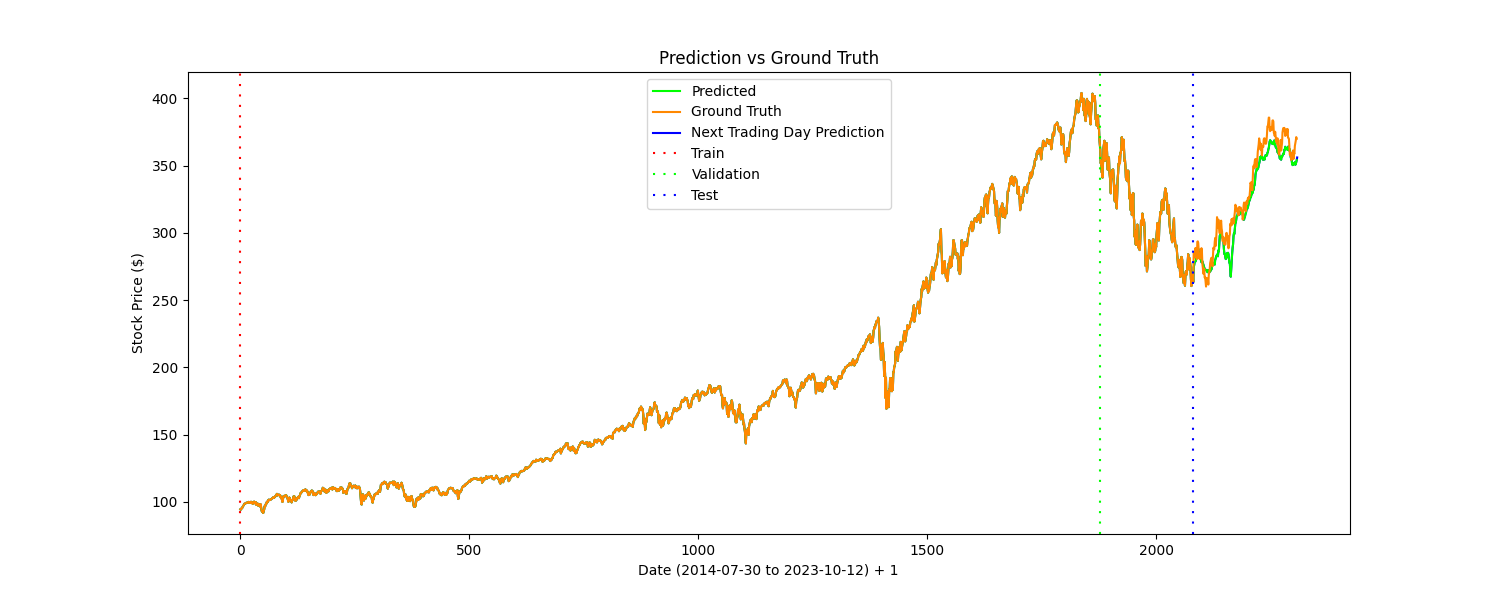

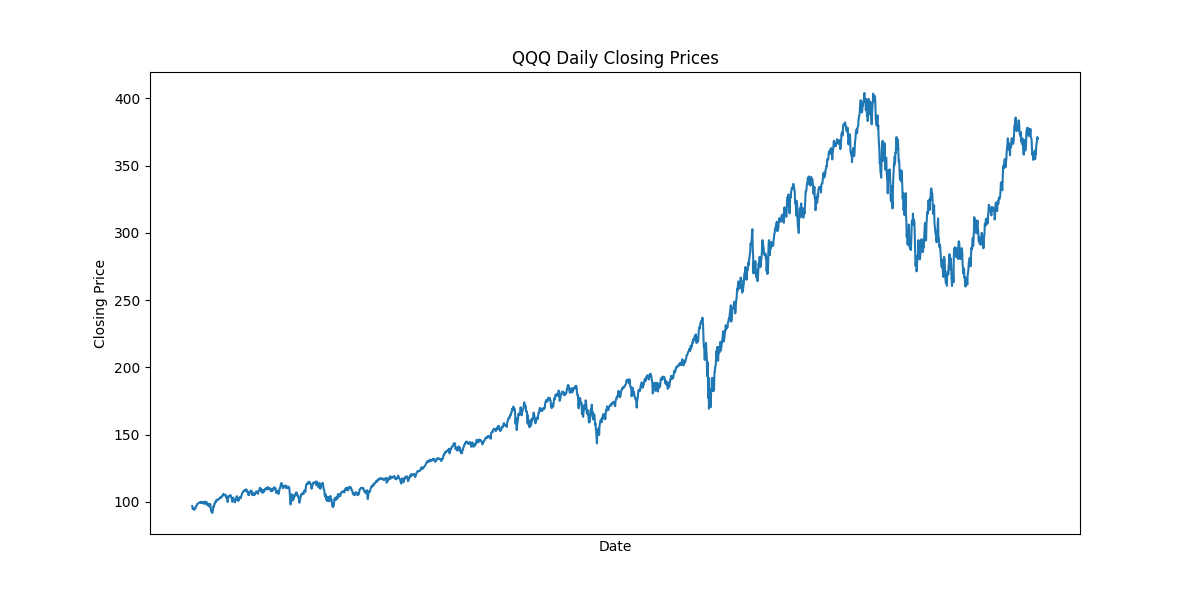

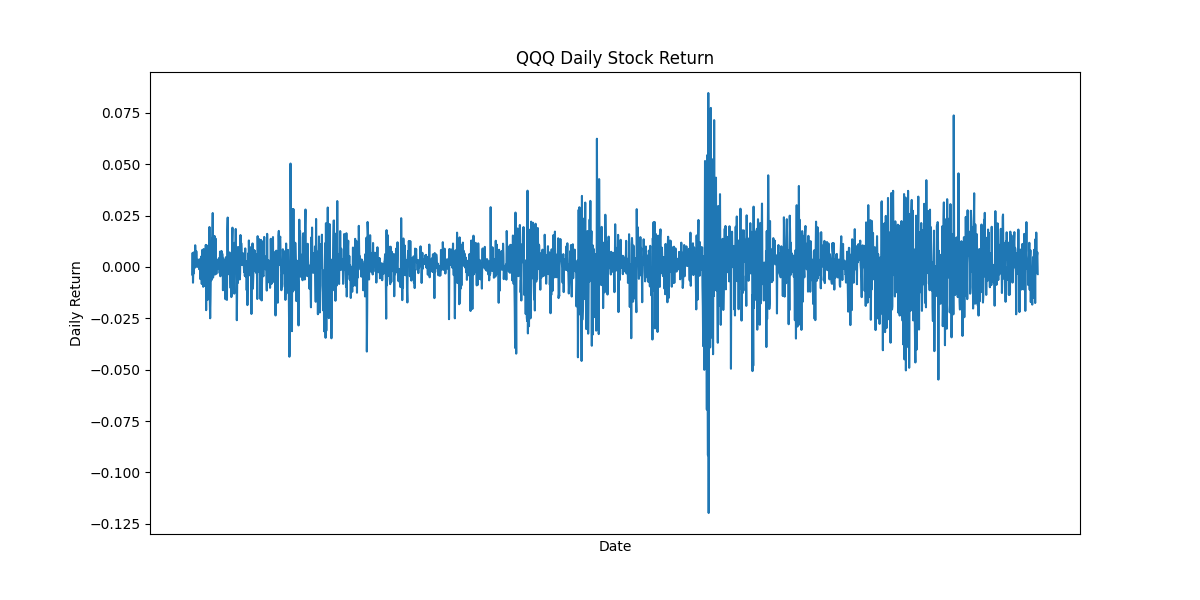

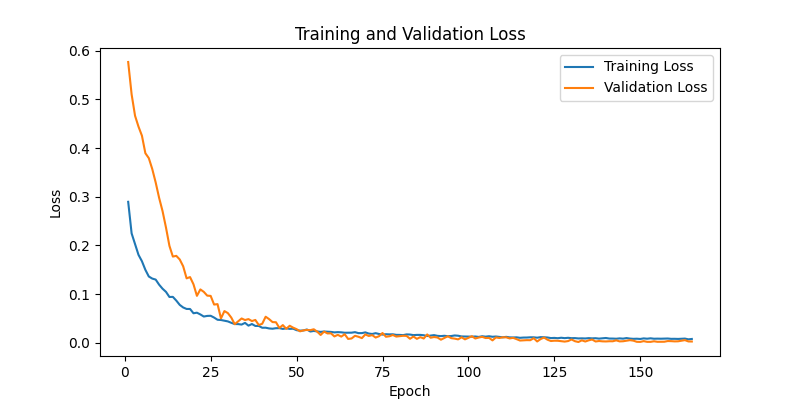

Number of times the model predicted CORRECT direction: 113
Number of times the model predicted INCORRECT direction: 112
Number of times the model predicted UNDER 2% tolerance: 56
Number of times the model predicted OVER 2% tolerance: 169
Number of times the model CORRECTLY predicted UPWARD movement UNDER 2% tolerance: 10
Number of times the model CORRECTLY predicted UPWARD movement OVER 2% tolerance: 7
Number of times the model CORRECTLY predicted DOWNWARD movement UNDER 2% tolerance: 36
Number of times the model CORRECTLY predicted DOWNWARD movement OVER 2% tolerance: 60
Number of times the model INCORRECTLY predicted UPWARD movement UNDER 2% tolerance: 4
Number of times the model INCORRECTLY predicted UPWARD movement OVER 2% tolerance: 7
Number of times the model INCORRECTLY predicted DOWNWARD movement UNDER 2% tolerance: 6
Number of times the model INCORRECTLY predicted DOWNWARD movement OVER 2% tolerance: 95


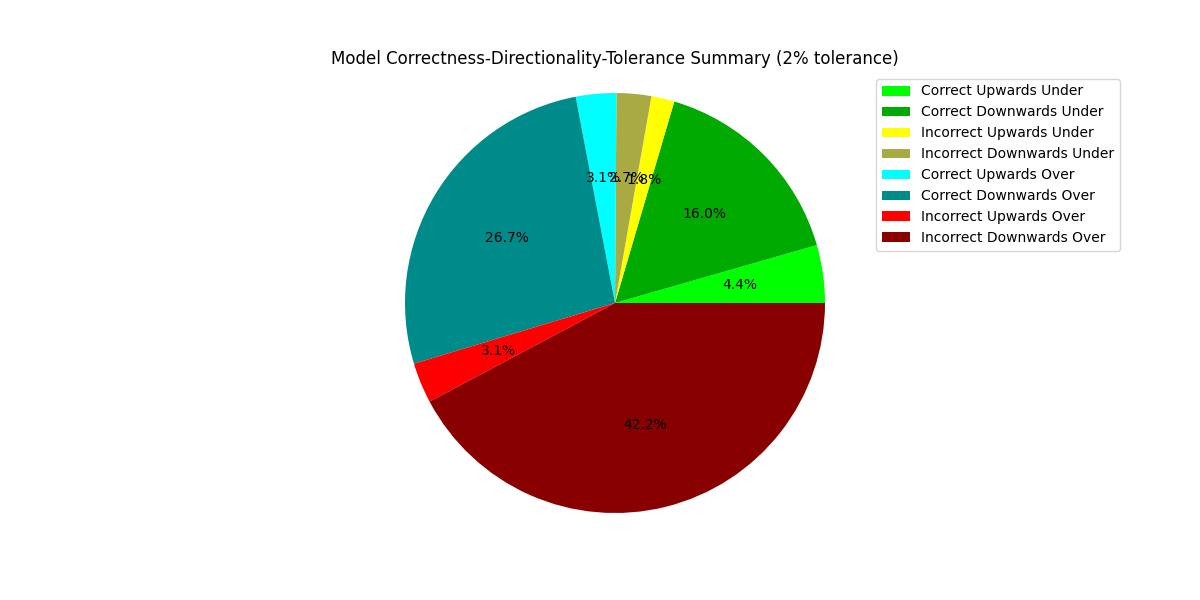

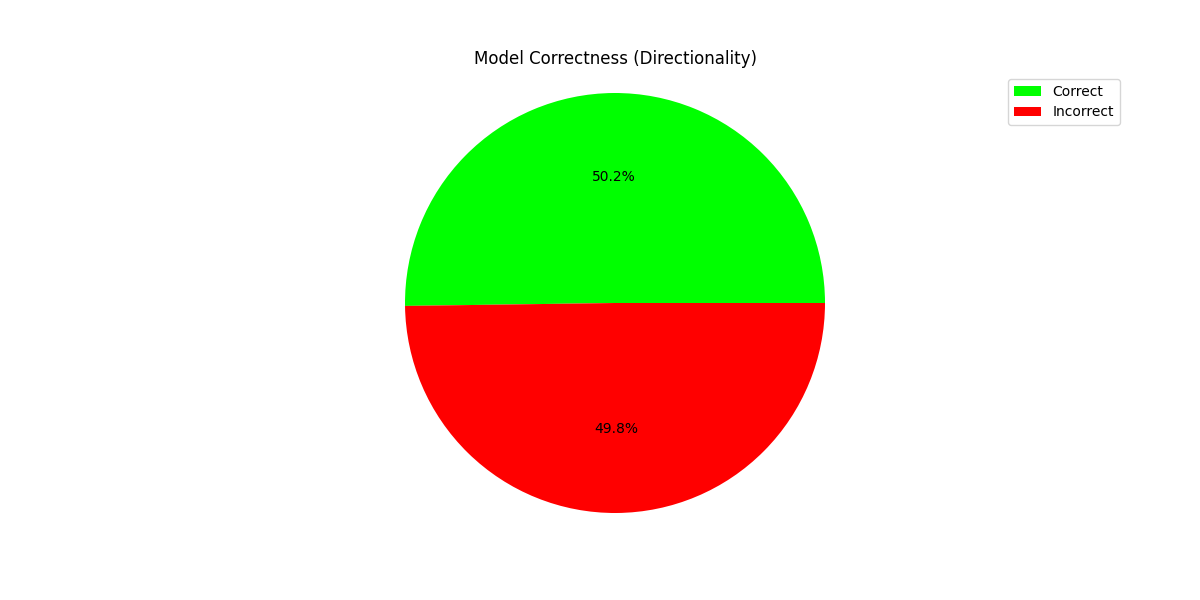

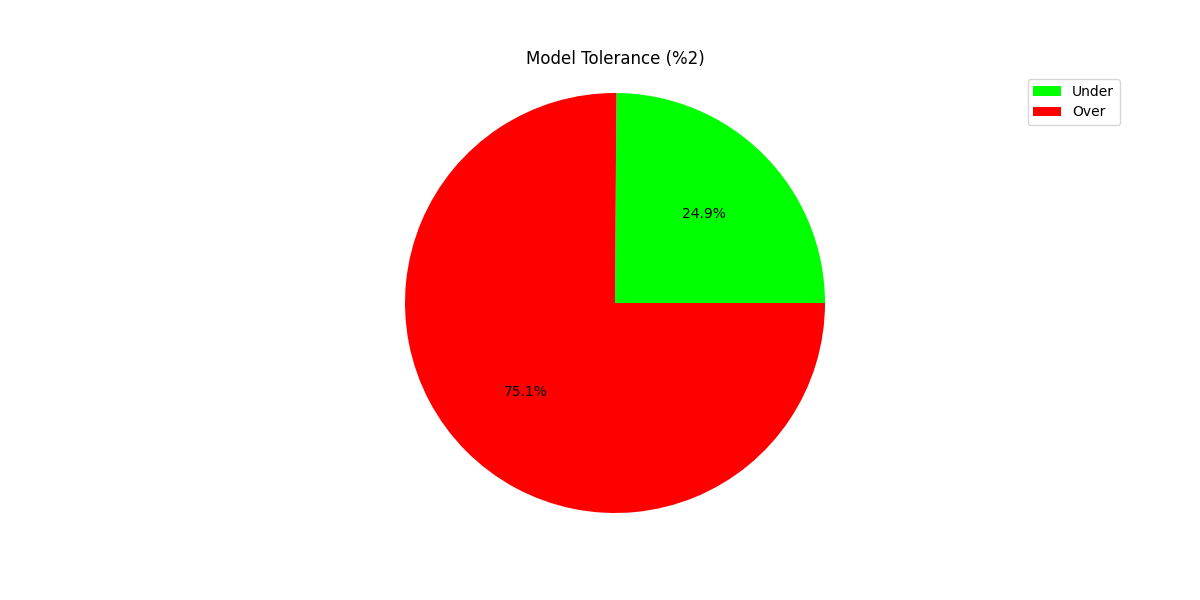

In [996]:
plot_prediction_vs_gt(scaler, predicted_x_axis, ground_truth_x_axis, start_date, end_date, train_data_len, train_validation_split, sliding_window_size)
plot_daily_close(df_copy, ticker)
plot_daily_returns(df_copy, ticker)
plot_loss_chart(history)

(correct, incorrect, under, over, 
        correct_upwards_under, correct_upwards_over, correct_downwards_under, correct_downwards_over, 
        incorrect_upwards_under, incorrect_upwards_over, incorrect_downwards_under, incorrect_downwards_over
        ) = calculate_pie_chart_values(y_test_sw, predicted_values, tolerance_percent=tolerance_percent)

plot_pie_categories(
        tolerance_percent, 
        correct_upwards_under, correct_downwards_under, incorrect_upwards_under, incorrect_downwards_under, 
        correct_upwards_over, correct_downwards_over, incorrect_upwards_over, incorrect_downwards_over)
plot_pie_correctness(correct, incorrect)
plot_pie_tolerance(tolerance_percent, under, over)
